# Mark Six: Bayesian hierarchical frequency analysis and short-term forecasting

This notebook implements a Bayesian hierarchical model to analyze the empirical drawing frequencies of numbers 1–49 and demonstrates how to produce conservative short-term predictive summaries from the posterior.

## Notebook highlights

- Use `get_lottery_data` to fetch and process historical draws
- Perform exploratory checks and a quick conjugate Dirichlet check
- Build a hierarchical Bayesian model in PyMC and run MCMC
- Run convergence diagnostics (R-hat, ESS, divergences) and a compact PPC
- Demonstrate a posterior-based short-term forecast (e.g., next 5 periods)

> Note: This notebook is for research and demonstration only. It is not betting or financial advice. To reproduce results, run all cells in order.

### Fetching historical draw data

This cell uses the `get_lottery_data` helper to fetch historical draw records from a local or remote source.

Inputs: start and end dates. Output: a list or DataFrame where each record contains the drawn numbers and metadata for the draw.

Execution notes:
- If the function returns a list of dicts (not a DataFrame), downstream code assumes that structure.
- After fetching, inspect the first row (the cell prints a sample) and verify field names such as `drawResult`, `drawnNo`, or `xDrawnNo` before further parsing.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import sys
import os

# If the project package path isn't on sys.path, temporarily add the parent path
# so helper functions can be imported. Remove or replace with package install if needed.
sys.path.append(
    os.path.join(os.getcwd(), "..", "..")
)  # optional: remove or turn into package

from get_lottery_data import get_lottery_data

# Fetch data (example: from 2025-01-01 to today)
print("Fetching historical draw data...")
data = get_lottery_data(
    start_date="2025-01-01", end_date=pd.Timestamp.today().strftime("%Y-%m-%d")
)
print(f"Fetched {len(data)} draw records")

# Show the first record for inspection (if the result is a list of dicts)
try:
    print("Sample record (first):", data[0])
except Exception:
    print(
        "Data is not list-like or sampling failed; check get_lottery_data return format"
    )

Fetching historical draw data...
Date range is larger than 3 months, splitting the request from 2025-01-01 00:00:00 to 2025-10-26 00:00:00
Fetching data from 20250101 to 20250401
Fetching data from 20250402 to 20250701
Fetching data from 20250702 to 20250930
Fetching data from 20251001 to 20251026
Fetched 115 draw records
Sample record (first): {'id': '2025115N', 'year': '2025', 'no': 115, 'openDate': '2025-10-23+08:00', 'closeDate': '2025-10-25T21:15:00+08:00', 'drawDate': '2025-10-25+08:00', 'status': 'Result', 'snowballCode': '', 'snowballName_en': '', 'snowballName_ch': '', 'lotteryPool': {'sell': False, 'status': 'Payout', 'totalInvestment': '75643571', 'jackpot': '31940095', 'unitBet': 10, 'estimatedPrize': '', 'derivedFirstPrizeDiv': '40000000', 'lotteryPrizes': [{'type': 1, 'winningUnit': 0, 'dividend': '0'}, {'type': 2, 'winningUnit': 20, 'dividend': '1424430'}, {'type': 3, 'winningUnit': 1170, 'dividend': '64930'}, {'type': 4, 'winningUnit': 2565, 'dividend': '9600'}, {'type'

### Parsing and inspecting the raw data

This cell parses raw draw records, extracts the main numbers and the special number for each draw, and prints summary information (number of periods, total draws, and the first entries of the Y vector).

Notes:
- The code merges main balls and the special ball into a single list `all_numbers`, then uses `collections.Counter` to compute counts.
- Verify that `N_periods`, `total_draws`, and `sum(y)` match (should equal 7 * N_periods).
- If field names differ in your data source, adjust the code that accesses `draw['drawResult']` accordingly.

In [2]:
# Data processing: count number occurrences

all_numbers = []
for draw in data:
    if "drawResult" in draw:
        result = draw["drawResult"]
        if "drawnNo" in result:
            all_numbers.extend(result["drawnNo"])
        if "xDrawnNo" in result:
            all_numbers.append(result["xDrawnNo"])

# Compute frequencies
count = Counter(all_numbers)
y = [count.get(i, 0) for i in range(1, 50)]

N_periods = len(data)
total_draws = 7 * N_periods

print(f"Number of observed periods N = {N_periods}")
print(f"Total number of draws = {total_draws}")
print(f"Y vector (first 10): {y[:10]}")
print(f"Total occurrences: {sum(y)}")

Number of observed periods N = 115
Total number of draws = 805
Y vector (first 10): [16, 11, 15, 15, 13, 20, 16, 14, 13, 7]
Total occurrences: 805


### Constructing the frequency vector Y

This cell summarizes the parsed numbers into an integer vector `y` of length 49, where `y[n-1]` is the total number of times number n appeared in the selected window.

Outputs and checks:
- `y` can be used directly for quick conjugate Dirichlet–Multinomial checks or as the observed counts in the full hierarchical model.
- If `sum(y)` != `7 * N_periods`, check for missing draws or parsing errors.

In [3]:
# Quick conjugate check: posterior under a flat Dirichlet prior (exploratory)
# Note: this is a simple exploratory check, not the formal hierarchical posterior.
alpha_prior = [1] * 49  # flat prior
alpha_posterior = [a + yy for a, yy in zip(alpha_prior, y)]

# Sample from Dirichlet posterior (seed fixed for reproducibility)
np.random.seed(42)
p_samples = np.random.dirichlet(alpha_posterior, 10000)
mean_p = np.mean(p_samples, axis=0)
ci_low = np.percentile(p_samples, 2.5, axis=0)
ci_high = np.percentile(p_samples, 97.5, axis=0)

uniform = 1 / 49
# Decision rule: if 95% CI is entirely above or below the uniform value, flag as significant
significant = [
    i + 1
    for i, (lo, hi) in enumerate(zip(ci_low, ci_high))
    if (lo > uniform or hi < uniform)
]
print(
    "Quick conjugate check - numbers significantly different from uniform (95% CI):",
    significant,
)
print("Uniform probability:", uniform)
if len(significant) > 0:
    for num in significant[:10]:  # show up to the first 10
        idx = num - 1
        print(
            f"Number {num}: posterior mean {mean_p[idx]:.4f}, 95% CI [{ci_low[idx]:.4f}, {ci_high[idx]:.4f}]"
        )
else:
    print("No significant deviations in this quick check")

Quick conjugate check - numbers significantly different from uniform (95% CI): [10, 32, 38, 45]
Uniform probability: 0.02040816326530612
Number 10: posterior mean 0.0094, 95% CI [0.0040, 0.0169]
Number 32: posterior mean 0.0352, 95% CI [0.0237, 0.0482]
Number 38: posterior mean 0.0117, 95% CI [0.0056, 0.0199]
Number 45: posterior mean 0.0317, 95% CI [0.0210, 0.0445]


### Quick check: posterior under a flat Dirichlet prior

This cell performs a fast, exploratory check using a flat Dirichlet prior (α = 1) combined with the observed counts to draw Dirichlet posterior samples. This is a quick, conjugate check (not the final hierarchical model) used to screen for numbers that may significantly deviate from uniformity.

Procedure:
- Compute the posterior Dirichlet parameters α_post = 1 + y.
- Draw many Dirichlet samples and compute the posterior mean and 95% credible intervals for each p_n.
- If a 95% CI lies completely above or below 1/49, the number is flagged as significant in this crude check.

This is exploratory only — it does not replace the full hierarchical analysis.

In [4]:
# Install PyMC (if needed)
# !pip install pymc

### Define the hierarchical Bayesian model (PyMC)

This cell defines the full hierarchical model in PyMC using a non-centered parameterization for the per-number random effects and a DirichletMultinomial observation (marginalizing p).

Model notes:
- Model `log_alpha` in log-space (ensures positivity of α) with terms `log_alpha0 + beta * z + eps`.
- Use non-centered reparameterization for `eps` (eps_raw * sigma) to improve sampling for high-dimensional random effects.
- Using `DirichletMultinomial` marginalizes out p and usually improves sampling efficiency compared to explicitly sampling p.

Execution tips:
- Confirm `y` and `total_draws` are correctly computed before running.
- MCMC can be slow; run a small test (reduced draws/tune) first, then increase draws/tune for final runs.
- If convergence warnings appear (high R-hat, divergences), increase `tune`, adjust `target_accept`, or try alternative parameterizations.

In [5]:
# Hierarchical Bayesian model (PyMC): non-centered parameterization and DirichletMultinomial marginalization of p
# Design notes:
# - Model alpha in log-space to ensure positivity and numerical stability
# - Use a non-centered reparameterization for eps (eps_raw * sigma) to improve mixing for high-dim random effects
# - Marginalize p using DirichletMultinomial to reduce state-space and improve sampling efficiency
# - If you see divergences or high R-hat, increase tune or consider a low-rank reparameterization for eps
import pymc as pm

# Covariate: positional baseline (simple linear coordinates, length 49)
z = np.linspace(-1, 1, 49)

with pm.Model() as model:
    # Priors (conservative defaults)
    log_alpha0 = pm.Normal("log_alpha0", mu=0.0, sigma=1.0)
    beta = pm.Normal("beta", mu=0.0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.3)

    # non-centered eps (high-dimensional random effects)
    eps_raw = pm.Normal("eps_raw", mu=0.0, sigma=1.0, shape=49)
    eps = pm.Deterministic("eps", eps_raw * sigma)

    # log_alpha -> alpha (positive values)
    log_alpha = log_alpha0 + beta * z + eps
    alpha = pm.math.exp(log_alpha)
    alpha = pm.Deterministic(
        "alpha", alpha
    )  # save to allow posterior reconstruction of p

    # Observation: DirichletMultinomial (marginalizing p)
    Y_obs = pm.DirichletMultinomial("Y_obs", n=total_draws, a=alpha, observed=y)

    # Sampling settings: increase chains to 4 if resources allow for better convergence diagnostics
    print(
        "Starting MCMC sampling (DirichletMultinomial); recommend chains >= 2 (4 if resources allow)..."
    )
    trace = pm.sample(
        draws=2000,
        tune=4000,
        target_accept=0.95,
        init="adapt_diag",
        random_seed=42,
        cores=1,
    )
    print("MCMC finished")

Starting MCMC sampling (DirichletMultinomial); recommend chains >= 2 (4 if resources allow)...


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [log_alpha0, beta, sigma, eps_raw]


Output()

Sampling 2 chains for 4_000 tune and 2_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC finished


## Posterior-based short-term prediction (demo)

This section demonstrates a conservative workflow for short-term prediction (example: next 5 periods):

Method overview:

1. Extract posterior samples of α (or p) from the fitted hierarchical model.
2. For each posterior sample, draw p ~ Dirichlet(α) (if α is stored), then treat p as the multinomial parameter for future draws.
3. Simulate the total draws for F future periods (7F draws total) using Multinomial(7F, p).
4. Compute expected counts and 95% prediction intervals for each number, and compare them with the uniform expectation (7F/49).

Interpretation notes:
- Predictions reflect posterior uncertainty rather than deterministic outcomes; they are summaries conditional on the model and data used.
- For computational efficiency, subsample posterior draws (e.g., up to 1000) before predictive simulation. Fix the RNG seed for reproducibility.
- Report full posterior predictive distributions (histograms or violin plots) when possible to communicate uncertainty.

The following code cells perform simulation, assemble a tidy DataFrame of results, and plot average deviations from uniform for the forecast window.

raw alpha_samples shape: (49, 4000)
Transposed alpha_samples; new shape: (4000, 49)
Generated p_samples shape: (1000, 49)
Using 1000 posterior samples to simulate next 5 periods (total 35 draws)
Top 10 numbers by mean increase relative to uniform expectation (next 5 periods):


,number,mean,ci_low,ci_high,increase,rel_increase_pct
0,32,0.823,0.0,3.0,0.108714,15.22
1,45,0.801,0.0,3.0,0.086714,12.14
2,7,0.759,0.0,3.0,0.044714,6.26
3,10,0.754,0.0,3.0,0.039714,5.56
4,13,0.754,0.0,3.0,0.039714,5.56
5,39,0.754,0.0,3.0,0.039714,5.56
6,21,0.751,0.0,3.0,0.036714,5.14
7,24,0.745,0.0,3.0,0.030714,4.30
8,42,0.743,0.0,3.0,0.028714,4.02
9,49,0.738,0.0,3.0,0.023714,3.32


Number 32: mean 0.8, 95% CI [0.0, 3.0], increase vs uniform 0.1 (15.2%)
Number 45: mean 0.8, 95% CI [0.0, 3.0], increase vs uniform 0.1 (12.1%)
Number 7: mean 0.8, 95% CI [0.0, 3.0], increase vs uniform 0.0 (6.3%)
Number 10: mean 0.8, 95% CI [0.0, 3.0], increase vs uniform 0.0 (5.6%)
Number 13: mean 0.8, 95% CI [0.0, 3.0], increase vs uniform 0.0 (5.6%)


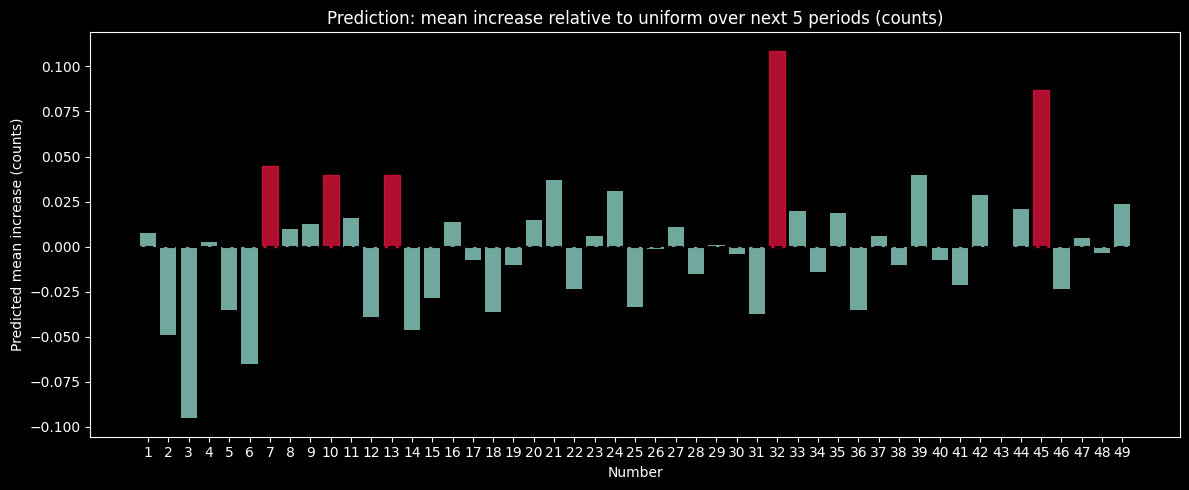

In [6]:
# Posterior predictive simulation for the next 5 periods (35 draws total)

future_periods = 5
future_draws = 7 * future_periods  # 7 numbers per period (including special ball)

# Extract posterior samples of alpha from trace, and draw p ~ Dirichlet(alpha) for each sample
alpha_samples = trace.posterior.alpha.stack(
    sample=("chain", "draw")
).values  # expected shape: (n_samples, 49) or (49, n_samples)
print("raw alpha_samples shape:", alpha_samples.shape)
# Sometimes xarray places the 49 dimension on axis 0 (shape (49, n_samples)); transpose if needed
if alpha_samples.shape[0] == 49 and alpha_samples.shape[1] != 49:
    alpha_samples = alpha_samples.T
    print("Transposed alpha_samples; new shape:", alpha_samples.shape)
# For efficiency, subsample alpha samples if there are too many
max_alpha_for_p = 1000
if alpha_samples.shape[0] > max_alpha_for_p:
    rng = np.random.default_rng(42)
    idx = rng.choice(alpha_samples.shape[0], size=max_alpha_for_p, replace=False)
    alpha_sub = alpha_samples[idx]
else:
    alpha_sub = alpha_samples
# Draw p ~ Dirichlet(alpha_sub) for each alpha_sub -- ensure each alpha_sub has shape (49,)
p_samples = np.array(
    [np.random.dirichlet(a) for a in alpha_sub]
)  # shape: (n_samples, 49)
print("Generated p_samples shape:", p_samples.shape)

# For readability and efficiency, subsample posterior p_samples if there are too many
max_samples = 1000
if p_samples.shape[0] > max_samples:
    rng = np.random.default_rng(42)
    idx = rng.choice(p_samples.shape[0], size=max_samples, replace=False)
    p_samples_sub = p_samples[idx]
else:
    p_samples_sub = p_samples

# Ensure each row is a valid probability vector: handle NaN/negative values and renormalize
p_samples_sub = np.asarray(p_samples_sub, dtype=float)
# Replace NaN with 0 and clamp negative values to 0
p_samples_sub = np.nan_to_num(p_samples_sub, nan=0.0)
p_samples_sub[p_samples_sub < 0] = 0.0

# Compute row sums and renormalize; if a row sums to 0, use uniform distribution
row_sums = p_samples_sub.sum(axis=1, keepdims=True)
zero_rows = row_sums.flatten() == 0
if zero_rows.any():
    p_samples_sub[zero_rows] = np.ones(49) / 49
    row_sums = p_samples_sub.sum(axis=1, keepdims=True)

p_samples_sub = p_samples_sub / row_sums

n_samples = p_samples_sub.shape[0]
print(
    f"Using {n_samples} posterior samples to simulate next {future_periods} periods (total {future_draws} draws)"
)

# Simulate multinomial outcomes for each posterior sample
sim_counts = np.empty((n_samples, 49), dtype=int)
for i in range(n_samples):
    # np.random.multinomial requires probability rows to sum to 1
    sim_counts[i] = np.random.multinomial(future_draws, p_samples_sub[i])

# Compute statistics: mean and 95% CI
mean_future = sim_counts.mean(axis=0)
ci_low = np.percentile(sim_counts, 2.5, axis=0)
ci_high = np.percentile(sim_counts, 97.5, axis=0)

# Compare to uniform expectation
uniform_counts = future_draws / 49
increase = mean_future - uniform_counts
rel_increase_pct = 100 * increase / uniform_counts

# Build DataFrame for display and sorting
import pandas as pd

nums = np.arange(1, 50)
pred_df = pd.DataFrame(
    {
        "number": nums,
        "mean": mean_future,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "increase": increase,
        "rel_increase_pct": rel_increase_pct,
    }
)

pred_df = pred_df.sort_values("increase", ascending=False).reset_index(drop=True)

# Display top 10 numbers by predicted increase
print(
    f"Top 10 numbers by mean increase relative to uniform expectation (next {future_periods} periods):"
)
from IPython.display import display

display(pred_df.head(10))

# Formatted textual output (short)
for i, row in pred_df.head(5).iterrows():
    num = int(row["number"])
    mean_val = float(row["mean"])
    ci_l = float(row["ci_low"])
    ci_h = float(row["ci_high"])
    inc = float(row["increase"])
    rel = float(row["rel_increase_pct"])
    print(
        f"Number {num}: mean {mean_val:.1f}, 95% CI [{ci_l:.1f}, {ci_h:.1f}], increase vs uniform {inc:.1f} ({rel:.1f}%)"
    )

# Plot predicted differences and highlight top 5
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
bars = plt.bar(pred_df["number"], pred_df["increase"], alpha=0.8)
# Color top 5 bars
top5_numbers = pred_df["number"].head(5).values
for b, n in zip(bars, pred_df["number"]):
    if n in top5_numbers:
        b.set_color("crimson")

plt.axhline(0, color="k", linestyle="--")
plt.title(
    f"Prediction: mean increase relative to uniform over next {future_periods} periods (counts)"
)
plt.xlabel("Number")
plt.ylabel("Predicted mean increase (counts)")
plt.xticks(range(1, 50))
plt.tight_layout()
plt.show()

# Note: for stricter reporting, also output full posterior predictive distributions (e.g., per-number hist/violin plots).

In [7]:
# Compact diagnostics: chains, divergences, max R-hat, min ESS, alpha checks and approximate p posterior
import arviz as az
import numpy as np

# Chains (if available)
try:
    n_chains = trace.posterior.sizes.get("chain", None)
except Exception:
    n_chains = None
print(f"Chains: {n_chains}")

# Divergences
try:
    divergences = int(np.sum(trace.sample_stats["diverging"].values))
except Exception:
    divergences = None
print("Divergences:", divergences)

# Max R-hat across stored variables (compact)
try:
    rhat_ds = az.rhat(trace)
    rhat_max = float(np.nanmax(rhat_ds.to_array().values))
    print(f"Max R-hat (all vars): {rhat_max:.3f}")
except Exception as e:
    print("Could not compute R-hat:", e)

# Min ESS across stored variables (compact)
try:
    ess_ds = az.ess(trace)
    ess_min = float(np.nanmin(ess_ds.to_array().values))
    print(f"Min ESS (all vars): {ess_min:.1f}")
except Exception as e:
    print("Could not compute ESS:", e)

# alpha posterior quick checks
try:
    alpha_samples = trace.posterior.alpha.stack(sample=("chain", "draw")).values
    # fix axis if necessary
    if alpha_samples.shape[0] == 49 and alpha_samples.shape[1] != 49:
        alpha_samples = alpha_samples.T
    print("alpha_samples shape:", alpha_samples.shape)
    print("alpha NaN count:", int(np.isnan(alpha_samples).sum()))
    print(
        "alpha min/max:",
        float(np.nanmin(alpha_samples)),
        float(np.nanmax(alpha_samples)),
    )
except Exception as e:
    print("Could not inspect alpha samples:", e)

# Reconstruct p posterior approximately and list significant numbers + top-5 deltas
try:
    max_draws = 2000
    if alpha_samples.shape[0] > max_draws:
        rng = np.random.default_rng(123)
        idx = rng.choice(alpha_samples.shape[0], size=max_draws, replace=False)
        alpha_sub = alpha_samples[idx]
    else:
        alpha_sub = alpha_samples
    p_draws = np.array([np.random.dirichlet(a) for a in alpha_sub])
    mean_p = p_draws.mean(axis=0)
    ci_low = np.percentile(p_draws, 2.5, axis=0)
    ci_high = np.percentile(p_draws, 97.5, axis=0)
    uniform = 1 / 49
    significant = [
        i + 1
        for i, (lo, hi) in enumerate(zip(ci_low, ci_high))
        if (lo > uniform or hi < uniform)
    ]
    print("Significant numbers (95% CI vs uniform):", significant)
    deltas = mean_p - uniform
    top5 = (np.argsort(-deltas)[:5] + 1).tolist()
    print("Top5 by expected delta:", top5)
except Exception as e:
    print("Could not reconstruct p posterior or compute significance:", e)

Chains: 2
Divergences: 0
Max R-hat (all vars): 1.003
Min ESS (all vars): 1855.9
alpha_samples shape: (4000, 49)
alpha NaN count: 0
alpha min/max: 5.087459076018588 150.5366718613037
Significant numbers (95% CI vs uniform): []
Top5 by expected delta: [45, 32, 49, 39, 44]
